# Introduction

This notebook explores the analysis of candidate assessment data (simulated by **heuristic modeling**), using **Item Response Theory (IRT)**. The main goals are to test how effectively **IRT**-theory can filter out key patterns, such as candidate performance, question properties, and compare model-based ability estimates with simulated ground truth. Key steps include:  
 
- Fitting a **2PL IRT model** to estimate latent abilities ($\theta$), item discrimination ($a$), and item difficulty ($b$).  
- Visualizing item characteristic curves, candidate ability distributions, and relationships between ability and total score.  
- Comparing **heuristic abilities** with **2PL estimated latent abilities** to evaluate the model’s recovery of underlying patterns.  

This approach illustrates how simulation and IRT modeling can provide meaningful insights into candidate assessment, item effectiveness, and latent ability estimation.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
import seaborn as sns
from scipy.stats import linregress

In [48]:
# ------------------------------------------------------------
# 1. Load simulated data
# ------------------------------------------------------------
responses = pd.read_csv("data/assessment_results.csv")
questions = pd.read_csv("data/questions_metadata.csv")

# Extract only the response matrix (0/1 values)
response_matrix = responses[[col for col in responses.columns if col.startswith("Q")]].values
n_candidates, n_items = response_matrix.shape

display(responses.head(3))
display(response_matrix)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q19,Q20,ability,candidate_id,total_score,avg_score,conceptual_score,applied_score,critical_thinking_score,domain_specific_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.432748,1,5.0,0.25,0.25,0.0,0.444444,0.000000
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.720396,2,12.0,0.60,0.75,0.0,0.555556,0.666667
2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.847320,3,13.0,0.65,0.75,1.0,0.444444,0.833333


array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Item Response Theory (IRT) Model

The **Item Response Theory (IRT)** framework models the probability that a candidate with a given ability correctly answers an item based on the item’s characteristics.  
In the **2-Parameter Logistic (2PL) model**, this probability is expressed as:

$$
P(X_{ij} = 1 \mid \theta_i, a_j, b_j) = \frac{1}{1 + e^{-a_j(\theta_i - b_j)}}
$$

where:  
- $\theta_i$ = latent ability of candidate *i*  
- $a_j$ = discrimination parameter of item *j*  
- $b_j$ = difficulty parameter of item *j*  
- $X_{ij}$ = observed response (1 = correct, 0 = incorrect)

The model reflects that candidates with higher ability ($\theta_i$) have a greater probability of answering difficult items correctly, especially when the discrimination parameter ($a_j$) is high.

---

## Deriving the Likelihood

Given that each response is modeled as a **Bernoulli random variable**, the probability of observing a specific response $X_{ij}$ ($X_{ij}$ = 1 correct, $X_{ij}$ = 0 incorrect) is:

$$
P(X_{ij} \mid \theta_i, a_j, b_j) =
[P(X_{ij}=1 \mid \theta_i, a_j, b_j)]^{X_{ij}}
[1 - P(X_{ij}=1 \mid \theta_i, a_j, b_j)]^{1 - X_{ij}}
$$

Assuming independence of responses across items and candidates, the joint likelihood of observing all responses is the product of individual probabilities:

$$
L(\theta, a, b) =
\prod_{i=1}^{N} \prod_{j=1}^{M}
[P(X_{ij}=1 \mid \theta_i, a_j, b_j)]^{X_{ij}}
[1 - P(X_{ij}=1 \mid \theta_i, a_j, b_j)]^{1 - X_{ij}}
$$

---

### Why Use the Log-Likelihood?

Because the likelihood is a **product of many probabilities (often very small numbers)**, direct computation can lead to numerical underflow and make optimization unstable.  
Taking the logarithm transforms the product into a **sum**, making computation easier and more stable:

$$
\ell(\theta, a, b) = \log(L(\theta, a, b)) =
\sum_{i=1}^{N} \sum_{j=1}^{M}
\Big[
X_{ij} \log P(X_{ij}=1 \mid \theta_i, a_j, b_j)
+ (1 - X_{ij}) \log(1 - P(X_{ij}=1 \mid \theta_i, a_j, b_j))
\Big]
$$

We **maximize the likelihood** because it represents the set of parameter values $(\theta, a, b)$ that make the observed data **most probable under the model**. This ensures our parameter estimates best explain the observed responses according to the assumptions of the IRT framework. Maximizing this **log-likelihood** is equivalent to maximizing the original likelihood, but it simplifies differentiation and numerical optimization, allowing us to estimate the parameters $(\theta, a, b)$ efficiently using iterative algorithms such as gradient ascent or Expectation-Maximization (EM).


In [7]:
# ------------------------------------------------------------
# 2. Define IRT model functions
# ------------------------------------------------------------
def irt_probability(theta, a, b):
    """
    2-Parameter Logistic Model (2PL)
    P(correct | theta, a, b) = 1 / (1 + exp(-a*(theta - b)))
    theta: candidate ability
    a: discrimination (slope)
    b: difficulty (intercept)
    """
    return 1 / (1 + np.exp(-a * (theta - b)))

def log_likelihood(params, response_matrix):
    """
    Negative log-likelihood for optimization.
    params includes:
      - theta (candidate abilities)
      - a (item discriminations)
      - b (item difficulties)
    """
    n_candidates, n_items = response_matrix.shape
    theta = params[:n_candidates]
    a = params[n_candidates:n_candidates + n_items]
    b = params[n_candidates + n_items:]

    P = irt_probability(theta[:, None], a[None, :], b[None, :])
    # Avoid log(0) issues
    eps = 1e-6
    logL = response_matrix * np.log(P + eps) + (1 - response_matrix) * np.log(1 - P + eps)
    return -np.sum(logL)


# Optimization Method: L-BFGS-B

The **L-BFGS-B** (Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds) algorithm is a **gradient-based optimization method** used to efficiently maximize or minimize smooth functions subject to bound constraints.  
In this context, it is applied to find the parameters that **maximize the log-likelihood** of the 2PL IRT model.

### Key Characteristics
- Approximates the **Hessian matrix** (second derivatives) using limited memory, making it suitable for problems with many parameters.  
- Iteratively updates parameters in the direction that **increases the log-likelihood** (or decreases the negative log-likelihood).  
- Allows **bound constraints** on parameters (e.g., ensuring discrimination parameters remain positive).


## How the Optimization Process Works

The goal of the optimization process in the 2PL IRT model is to estimate the parameters that **maximize the likelihood** of the observed response data.  
Since we use numerical optimization, this is achieved by minimizing the **negative log-likelihood function**.

---

#### 1. Objective Function

The log-likelihood function for the 2PL model is:

$$
\ell(\theta, a, b) =
\sum_{i=1}^{N} \sum_{j=1}^{M}
\Big[
X_{ij} \log P_{ij} +
(1 - X_{ij}) \log(1 - P_{ij})
\Big]
$$

where

$$
P_{ij} = \frac{1}{1 + e^{-a_j(\theta_i - b_j)}}
$$

To turn this into a **minimization problem**, we define the **negative log-likelihood**:

$$
\mathcal{L}(\theta, a, b) = -\ell(\theta, a, b)
$$

The optimizer seeks parameters that minimize this objective function.

---

#### 2. Gradient-Based Optimization

The **L-BFGS-B algorithm** updates the parameters iteratively using gradient information. At each iteration $t$, the parameter vector $\mathbf{w}^{(t)} = [\theta, a, b]$ is updated as:

$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \alpha^{(t)} \mathbf{H}^{-1}_{(t)} \nabla \mathcal{L}(\mathbf{w}^{(t)})
$$

where:
- $\alpha^{(t)}$ is a step size (learning rate),
- $\nabla \mathcal{L}(\mathbf{w}^{(t)})$ is the gradient of the objective function,
- $\mathbf{H}^{-1}_{(t)}$ is an approximation of the **inverse Hessian matrix**, representing curvature information.

Instead of storing the full Hessian (which is large and costly), **L-BFGS-B** builds a low-memory approximation using only information from the most recent iterations (“limited memory”).

---

#### 3. The Hessian Matrix

The **Hessian matrix** is a square matrix of **second-order partial derivatives** of the objective function with respect to its parameters. It describes how the **gradient changes** as the parameters change.

For a function $\mathcal{L}(\mathbf{w})$ with parameters  
$\mathbf{w} = [w_1, w_2, \dots, w_k]$,  
the Hessian is defined as:

$$
\mathbf{H}(\mathbf{w}) =
\begin{bmatrix}
\frac{\partial^2 \mathcal{L}}{\partial w_1^2} & \frac{\partial^2 \mathcal{L}}{\partial w_1 \partial w_2} & \dots \\
\frac{\partial^2 \mathcal{L}}{\partial w_2 \partial w_1} & \frac{\partial^2 \mathcal{L}}{\partial w_2^2} & \dots \\
\vdots & \vdots & \ddots
\end{bmatrix}
$$

---

#### 4. Convergence

The process continues until the gradient norm becomes very small:

$$
\|\nabla \mathcal{L}(\mathbf{w})\| < \epsilon
$$

indicating that the algorithm has reached (or is very close to) a **local minimum** of the negative log-likelihood — and thus a **maximum** of the log-likelihood.

---

#### 5. Result

Once convergence is reached, the optimized parameters:

$$
\hat{\theta}, \hat{a}, \hat{b} = 
\arg\max_{\theta, a, b} \ \ell(\theta, a, b)
$$

represent the **maximum likelihood estimates** (MLEs) of the candidate abilities, item discriminations, and item difficulties.  
These estimates best explain the observed response data under the 2PL IRT model.


### Why the Second Derivative Represents Curvature

The **first derivative** (gradient) of a function tells us the **slope** — the direction and rate of change at a point. The **second derivative**, on the other hand, tells us **how that slope is changing** — in other words, the **curvature** of the function.

#### In One Dimension

For a simple function $f(x)$:

- $f'(x)$ = slope  
- $f''(x)$ = rate of change of the slope

If $f''(x) > 0$: the curve bends **upward** (convex, like a bowl)  
If $f''(x) < 0$: the curve bends **downward** (concave, like a hill)

So, the second derivative measures **how sharply** the function curves. A large magnitude of $f''(x)$ means a steep curve — either steeply rising or falling.

#### In Multiple Dimensions

When we move to a multivariate function $\mathcal{L}(\mathbf{w})$, we need to understand **how curvature behaves in every direction** in parameter space.  

That’s what the **Hessian matrix** does:

$$
\mathbf{H} =
\begin{bmatrix}
\frac{\partial^2 \mathcal{L}}{\partial w_1^2} & \frac{\partial^2 \mathcal{L}}{\partial w_1 \partial w_2} & \dots \\
\frac{\partial^2 \mathcal{L}}{\partial w_2 \partial w_1} & \frac{\partial^2 \mathcal{L}}{\partial w_2^2} & \dots \\
\vdots & \vdots & \ddots
\end{bmatrix}
$$

Each entry tells you how much the slope in one direction changes as you move along another. This defines the **shape of the surface** — whether it’s flat, sloped, or curved like a bowl.

---

### Why the Hessian is Needed in the Update Step

In the optimization update rule:

$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \alpha^{(t)} \mathbf{H}^{-1}_{(t)} \nabla \mathcal{L}(\mathbf{w}^{(t)})
$$

each term plays a geometric role:

- $\nabla \mathcal{L}(\mathbf{w}^{(t)})$:  
  The **gradient** points in the direction of steepest ascent —  its negative is the direction of steepest descent.

- $\mathbf{H}^{-1}_{(t)}$:  
  The **inverse Hessian** rescales and reorients the gradient based on the **local curvature**. It ensures we take smaller steps in directions where the function curves sharply, and larger steps in flatter directions.

Visually:

- If the loss surface were a perfect **sphere**, the gradient alone would work fine — same curvature everywhere.  
- But if it’s **elliptical** (steeper in one direction), the Hessian helps “stretch” and “rotate” the step so it heads straight toward the minimum instead of zigzagging.

That’s why the Hessian (or its approximation) is essential — it adjusts for **uneven curvature**, making convergence **faster and more stable**.


In [8]:
# ------------------------------------------------------------
# 3. Initialize parameters
# ------------------------------------------------------------
theta_init = np.random.normal(0, 1, n_candidates)
a_init = np.ones(n_items)
b_init = np.zeros(n_items)

params_init = np.concatenate([theta_init, a_init, b_init])

In [9]:
# ------------------------------------------------------------
# 4. Optimize using scipy
# ------------------------------------------------------------
print("Fitting 2PL IRT model (this may take a minute)...")

result = minimize(
    fun=log_likelihood,
    x0=params_init,
    args=(response_matrix,),
    method='L-BFGS-B',
    options={'maxiter': 500, 'disp': True}
)

print("Optimization complete.")

# Extract fitted parameters
params_opt = result.x
theta_hat = params_opt[:n_candidates]
a_hat = params_opt[n_candidates:n_candidates + n_items]
b_hat = params_opt[n_candidates + n_items:]

Fitting 2PL IRT model (this may take a minute)...
Optimization complete.


In [10]:
# ------------------------------------------------------------
# 5. Save parameter estimates
# ------------------------------------------------------------
candidate_irt = pd.DataFrame({
    'candidate_id': responses['candidate_id'],
    'theta_est': theta_hat
})

item_irt = pd.DataFrame({
    'question_id': range(1, n_items + 1),
    'a_est': a_hat,
    'b_est': b_hat,
    'skill_area': questions['skill_area']
})

candidate_irt.to_csv("data/candidate_irt_estimates.csv", index=False)
item_irt.to_csv("data/item_irt_parameters.csv", index=False)

print("Saved IRT parameter estimates in ./data/")

Saved IRT parameter estimates in ./data/


In [11]:
# ------------------------------------------------------------
# 6. Visualization
# ------------------------------------------------------------

# Combine item parameter estimates with their corresponding question info
parameter_table = pd.DataFrame({
    'Item ID': np.arange(1, n_items + 1),
    'Skill Area': questions['skill_area'],
    'Discrimination (a)': np.round(a_hat, 3),
    'Difficulty (b)': np.round(b_hat, 3)
})

# Display the first few rows for readability
display(parameter_table.head(3))

,Item ID,Skill Area,Discrimination (a),Difficulty (b)
0,1,critical_thinking,0.117,6.589
1,2,domain_specific,0.406,-0.874
2,3,conceptual,0.100,7.036
3,4,critical_thinking,0.085,8.557
4,5,critical_thinking,0.293,1.564
5,6,domain_specific,0.071,15.405
6,7,conceptual,0.069,15.443
7,8,conceptual,0.098,8.106
8,9,critical_thinking,0.074,11.670
9,10,applied,0.417,0.619


# Interpretation and Comparison of Estimated 2PL Parameters

The **2-Parameter Logistic (2PL)** model in Item Response Theory (IRT) describes the probability that a candidate with latent ability ($\theta$) correctly answers an item.  
It incorporates two item-specific parameters:  
- **Discrimination** ($a$): how well the item differentiates between candidates of different ability levels.  
- **Difficulty** ($b$): the ability level at which the candidate has a 50% chance of answering correctly.
$$
P(\text{correct}|\theta) = \frac{1}{1 + e^{-a(\theta - b)}}
$$


It was fitted to data generated from a **heuristic probability model**:

$$
P(\text{correct}) = \frac{A}{A + (1 - A) \cdot \frac{1}{D}}
$$

where,
- $A$ is the candidate’s ability, drawn from a **Beta(2,2) distribution** to capture realistic variability within [0,1]
- $D$ is the question difficulty, drawn from a **normal distribution** centered at 0.6 (and clipped between 0.1 and 0.9) to reflect moderate difficulty across questions.


## Candidate Latent Abilities ($\theta$)

The estimated $\theta$ values represent the inferred abilities of candidates under the 2PL model and should reflect the original Beta-distributed abilities $A$, though scaled to fit the logistic 2PL framework. Higher $\theta$ corresponds to candidates who are more likely to answer items correctly across varying difficulties.

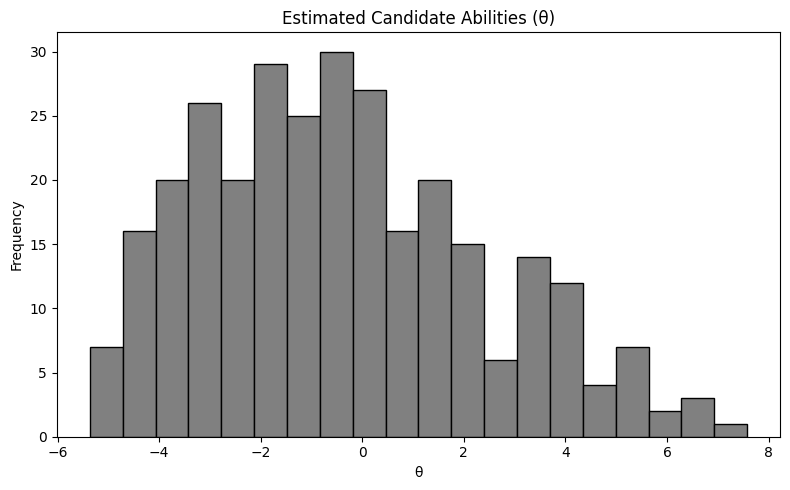

Plots saved in ./figures/


In [12]:
# Candidate ability distribution
plt.figure(figsize=(8, 5))
plt.hist(theta_hat, bins=20, color='gray', edgecolor='black')
plt.title("Estimated Candidate Abilities (θ)")
plt.xlabel("θ")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/candidate_ability_distribution.png")
plt.show()

print("Plots saved in ./figures/")

## Comparing Heuristic Ability (A) and Latent Ability (θ)

This plot visualizes the relationship between the **heuristic abilities (A)** used in the simulated data and the **latent abilities (θ)** estimated by the 2PL IRT model. 

- A clear positive linear trend indicates that the IRT model successfully recovers the underlying candidate ability structure
- Deviations from a perfect line reflect differences introduced by the model’s estimation process and random noise in the simulated responses. The regression equation and $R^2$ value quantify the strength and direction of this relationship.
- Scaling differences arise from the different mathematical relationship of both models used to fine-tune the various parameters to each other. While $\theta$ ranges around [-3, 3] or so after estimation, heuristic ability $A$ is in [0, 1]. The slope $\neq 1$ reflects these scaling differences


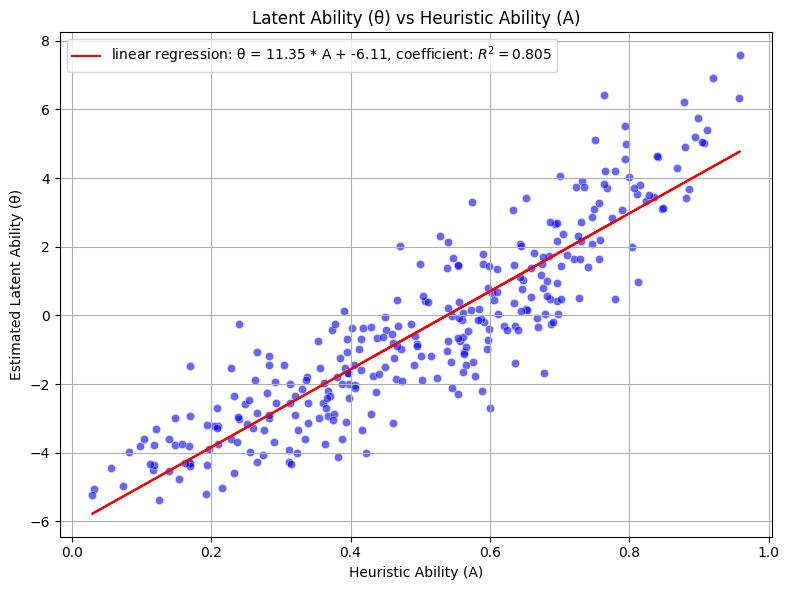

In [29]:
# Load data
assessment_df = pd.read_csv("data/assessment_results.csv")  # contains 'candidate_id', 'ability', 'total_score', etc.
candidate_irt = pd.read_csv("data/candidate_irt_estimates.csv")  # contains 'candidate_id' and 'theta_est'

# Merge both datasets
merged_df = pd.merge(assessment_df, candidate_irt, on='candidate_id')

# Compute regression
slope, intercept, r_value, p_value, std_err = linregress(merged_df['ability'], merged_df['theta_est'])

# Plot relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='ability', y='theta_est', color='blue', alpha=0.6)
plt.plot(merged_df['ability'], intercept + slope * merged_df['ability'], color='red', label=f'linear regression: θ = {slope:.2f} * A + {intercept:.2f}, coefficient: $R^2 = {r_value**2:.3f}$')
plt.title('Latent Ability (θ) vs Heuristic Ability (A)')
plt.xlabel('Heuristic Ability (A)')
plt.ylabel('Estimated Latent Ability (θ)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparing Candidate Ability vs Total Score: Heuristic vs 2PL Estimates

By comparing the two plots $A$ and $\theta$ wrt total assessment scores, we find that:
- the 2PL IRT model successfully recovers the positive relationship between candidate abilities and total assessment scores
- the different slopes account for the scaling differences between the parameters in both models. Indeed the plot recovers the $\approx 10$ x scaling between $\theta$ and $A$ we have estimated in the *Latent Ability ($\theta$) vs Heuristic Ability ($A$)*- plot.
- The different intercepts reflect the different baseline scores for candidates with low abilities $A$ and $\theta$, introduced by the scaling differences

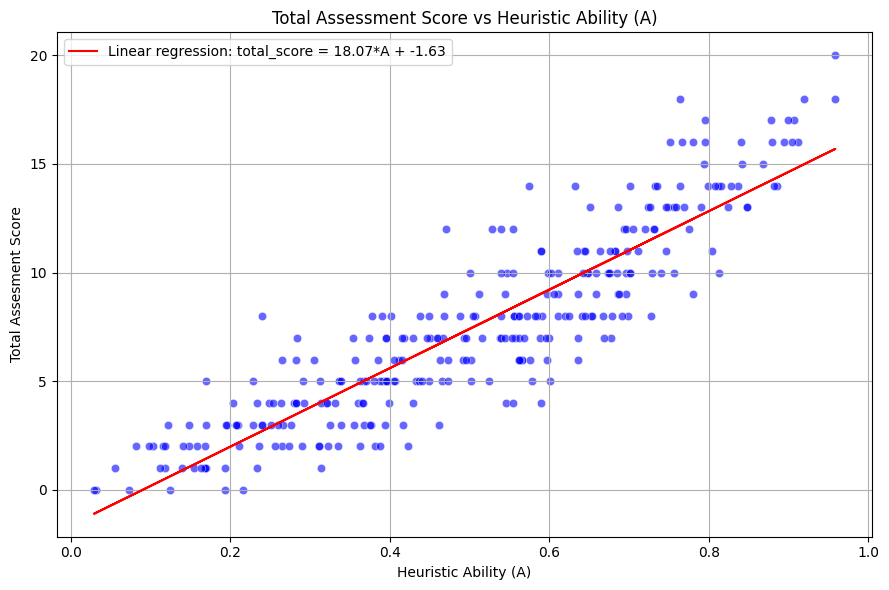

In [24]:
# Load data
assessment_df = pd.read_csv("data/assessment_results.csv")  # contains 'ability' and 'total_score'

# Compute regression
slope, intercept, r_value, p_value, std_err = linregress(assessment_df['ability'], assessment_df['total_score'])

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(data=assessment_df, x='ability', y='total_score', color='blue', alpha=0.6)
plt.plot(assessment_df['ability'], intercept + slope * assessment_df['ability'], color='red', label=f'Linear regression: total_score = {slope:.2f}*A + {intercept:.2f}')
plt.title('Total Assessment Score vs Heuristic Ability (A)')
plt.xlabel('Heuristic Ability (A)')
plt.ylabel('Total Assesment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


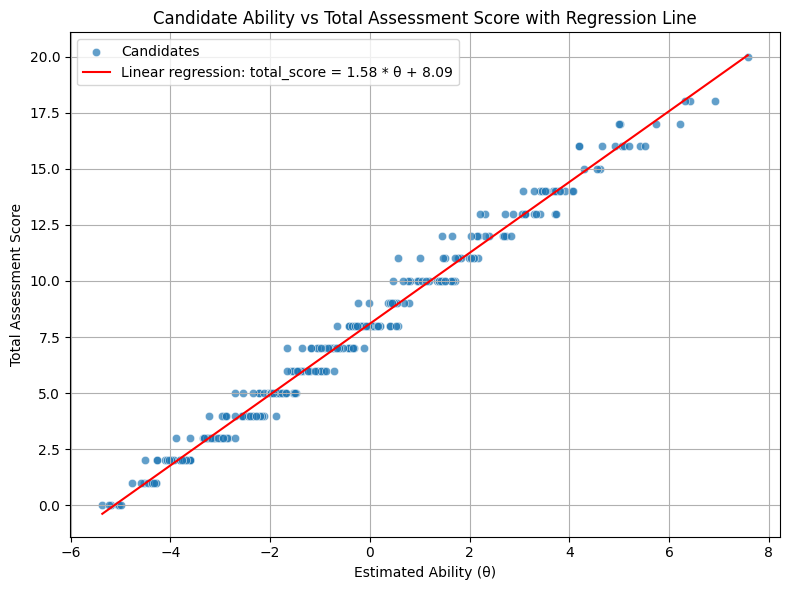

In [30]:
# Load saved IRT estimates and assessment results
candidate_irt = pd.read_csv("data/candidate_irt_estimates.csv")
assessment_df = pd.read_csv("data/assessment_results.csv")  # contains 'candidate_id' and 'total_score'

# Merge data on candidate_id
merged_df = pd.merge(candidate_irt, assessment_df[['candidate_id', 'total_score']], on='candidate_id')

# Fit linear regression line
slope, intercept = np.polyfit(merged_df['theta_est'], merged_df['total_score'], 1)

# Plot scatter with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='theta_est', y='total_score', alpha=0.7, label='Candidates')
sns.lineplot(x=merged_df['theta_est'], y=slope*merged_df['theta_est'] + intercept, color='red', label= f"Linear regression: total_score = {slope:.2f} * θ + {intercept:.2f}")
plt.xlabel("Estimated Ability (θ)")
plt.ylabel("Total Assessment Score")
plt.title("Candidate Ability vs Total Assessment Score with Regression Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison of Heuristic and 2PL Item Difficulties

The scatter plot and regression analysis compare the **heuristic item difficulties (D)** with the **estimated 2PL difficulty parameters (b)**.

- The linear regression equation with $R^2 = 0.784$ indicates a **strong relationship** between the two measures
- The **negative slope** suggests that the 2PL model scales difficulties differently than the heuristic model.
- Items with higher heuristic difficulty (D) tend to correspond to **lower b estimates** in the 2PL model due to the different parameterization and scale of the logistic function.

This comparison confirms that the 2PL estimation provides a **meaningful approximation of item difficulty**, even when the data is generated from a non-logistic heuristic probability model.


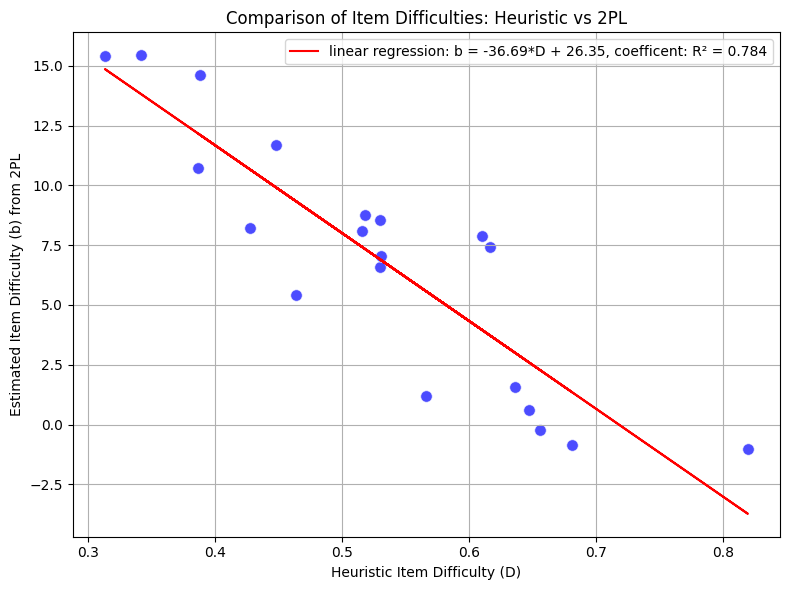

In [37]:
# Load item parameters
item_irt = pd.read_csv("data/item_irt_parameters.csv")  # contains 'question_id', 'b_est'
questions = pd.read_csv("data/questions_metadata.csv")  # contains 'question_id', 'difficulty' (D)

# Merge the two datasets on question_id
merged_items = pd.merge(item_irt, questions[['question_id', 'difficulty']], on='question_id')

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(merged_items['difficulty'], merged_items['b_est'])

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_items, x='difficulty', y='b_est', s=70, color='blue', alpha=0.7)
plt.plot(merged_items['difficulty'], slope * merged_items['difficulty'] + intercept, color='red', label=f'linear regression: b = {slope:.2f}*D + {intercept:.2f}, coefficent: R² = {r_value**2:.3f}')
plt.xlabel("Heuristic Item Difficulty (D)")
plt.ylabel("Estimated Item Difficulty (b) from 2PL")
plt.title("Comparison of Item Difficulties: Heuristic vs 2PL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison of Discrimination Parameter (a) to the Heuristic Model

In the 2PL IRT model, the **discrimination parameter ($a$)** reflects how strongly an item differentiates between candidates of different abilities — higher values indicate that small differences in ability lead to large differences in probability of answering correctly.  

In contrast, the **heuristic model**:

$$
P(\text{correct}) = \frac{A}{A + (1-A) \cdot \frac{1}{D}}
$$

does **not explicitly include a discrimination parameter**. All items follow the same functional form, so the “sensitivity” of each item to ability is implicitly determined by the item difficulty $D$ and the non-linear ratio formula.  

### Results

- Comparing $a$ across items allows us to **rank items by their discriminatory power**, even when the original data comes from a uniform heuristic formula.  
- Estimated $a$ values from the 2PL model reflect the **implicit ability sensitivity** encoded in the heuristic formula. Items with more extreme $D$ values or steeper probability changes will tend to have higher estimated $a$.The value of $R^2=0.579$ shows that heuristic difficulty explains a substantial but not complete portion of the variation in estimated discrimination. Thus, $a$ captures additional item-specific sensitivity not explicitly modeled in the heuristic function.  

In short, $a$ is a **latent property inferred from the data**, capturing item sensitivity that the heuristic model encodes indirectly through the non-linear combination of ability and difficulty.


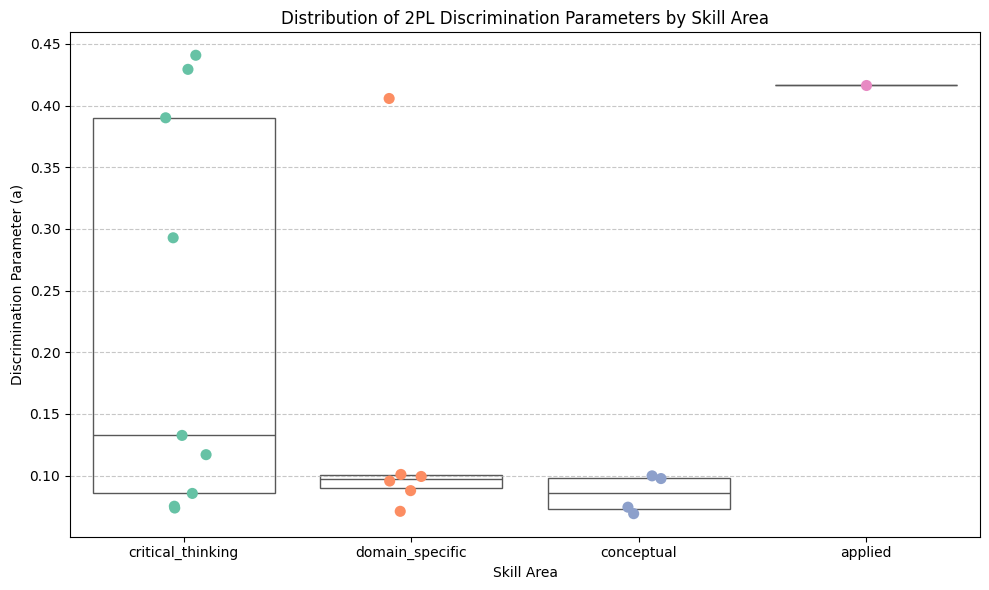

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load item parameters
item_irt = pd.read_csv("data/item_irt_parameters.csv")  # contains 'question_id', 'a_est', 'skill_area'

# Scatter plot grouped by skill area
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=item_irt,
    x='skill_area',
    y='a_est',
    hue='skill_area',
    jitter=True,
    size=8,
    palette='Set2',
    dodge=False,
    legend=False  # prevent duplicate legend
)


# Optionally, add a boxplot behind the points to show distribution
sns.boxplot(
    data=item_irt,
    x='skill_area',
    y='a_est',
    showcaps=False,
    boxprops={'facecolor':'None'},
    showfliers=False,
    whiskerprops={'linewidth':0},
    zorder=0
)

plt.xlabel('Skill Area')
plt.ylabel('Discrimination Parameter (a)')
plt.title('Distribution of 2PL Discrimination Parameters by Skill Area')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


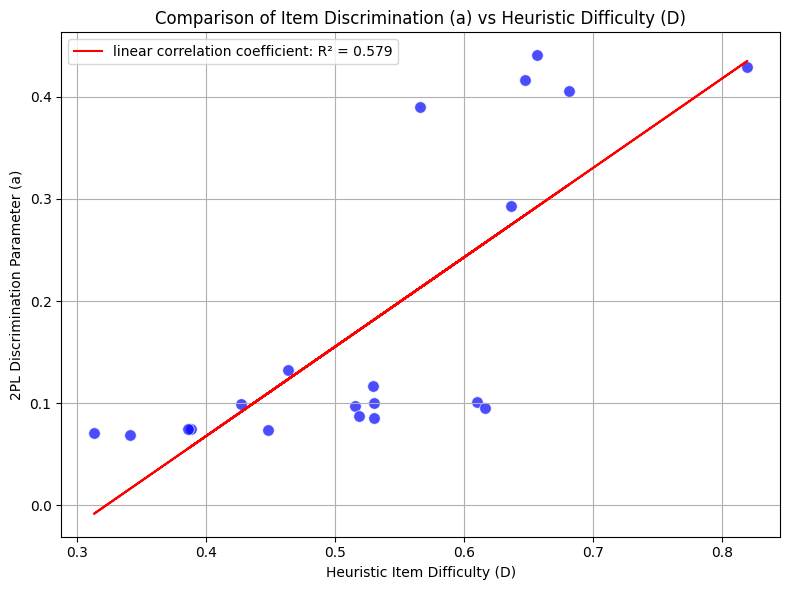

In [42]:
# Load item parameters
item_irt = pd.read_csv("data/item_irt_parameters.csv")  # contains 'question_id', 'a_est', 'b_est', 'skill_area'
questions = pd.read_csv("data/questions_metadata.csv")  # contains 'question_id', 'difficulty' (D)

# Merge the datasets on question_id
merged_items = pd.merge(item_irt, questions[['question_id', 'difficulty']], on='question_id')

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(merged_items['difficulty'], merged_items['a_est'])

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_items, x='difficulty', y='a_est', s=70, color='blue', alpha=0.7)
plt.plot(merged_items['difficulty'], slope * merged_items['difficulty'] + intercept, color='red', label=f'linear correlation coefficient: R² = {r_value**2:.3f}')
plt.xlabel("Heuristic Item Difficulty (D)")
plt.ylabel("2PL Discrimination Parameter (a)")
plt.title("Comparison of Item Discrimination (a) vs Heuristic Difficulty (D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion

This notebook demonstrates the analysis of candidate assessment data (obtained through a **heuristic probability model**), using **2PL IRT framework**. Key insights include:  

- **Candidate Abilities and Scores:** Total assessment scores show a clear positive relationship with both the heuristic abilities (A) and the latent abilities (θ) estimated by the 2PL model, validating the meaningfulness of θ.  
- **Item Characteristics:** The 2PL model successfully recovers item difficulties (b) and discrimination parameters (a) from data generated by the heuristic model, providing interpretable measures of item sensitivity and challenge.  
- **Relationship Between Models:** Estimated 2PL parameters correlate moderately with the original heuristic parameters, demonstrating that the IRT model captures underlying patterns even when data is not explicitly logistic.  
- **Practical Implications:** Latent ability estimates allow for ranking candidates, understanding item effectiveness, and potentially improving assessment design by identifying high-discrimination items and appropriately challenging questions.  

Overall, this analysis illustrates the value of **IRT estimation** to evaluate assessments and interpret candidate performance in a rigorous, data-driven way.